In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib
import sys
import xgboost as xgb
%matplotlib inline

sessions = pd.read_json("../data/raw/second/sessions.jsonl", lines=True)
buy_sessions = sessions[sessions['event_type'] == 'BUY_PRODUCT'].copy()
buy_sessions['purchase_id'] = buy_sessions['purchase_id'].astype(int)
buy_sessions['date']=buy_sessions['timestamp'].dt.date


In [ ]:
buy_sessions.drop(columns=['user_id', 'event_type', 'offered_discount','session_id','timestamp'], inplace=True)
products_per_day = buy_sessions.groupby(by=['date','product_id']).count().unstack(fill_value=0).stack().rename(columns={'purchase_id': 'amount'}).reset_index()
products_per_day['product_id']=products_per_day['product_id'].astype(str)
print(products_per_day)

In [ ]:
def date_features(df):
    # Date Features
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['dayofyear'] = df.date.dt.dayofyear
    df['dayofweek'] = df.date.dt.dayofweek
    df['weekofyear'] = df.date.dt.weekofyear
    # Additionnal Data Features
    df['day^year'] = np.log((np.log(df['dayofyear'] + 1)) ** (df['year'] - 2000))
    # Drop date
#     df.drop('date', axis=1, inplace=True)
    return df

In [ ]:
df=date_features(products_per_day)

In [ ]:
print(df)

In [ ]:
cutoff_point=int(len(df)*0.2)
train=df[:-cutoff_point]
test=df[-cutoff_point:]
print(len(train))
print(len(test))


In [ ]:
# train['day_of_week_avg']  = train.groupby(['product_id','dayofweek'])['amount'].transform('mean')
# train['monthly_avg'] = train.groupby(['product_id','month'])['amount'].transform('mean')
# train = train.dropna()
# # Average sales for Day_of_week = d per Item,Store
# day_of_week_avg = train.groupby(['product_id','dayofweek'])['amount'].mean().reset_index()
# # Average sales for Month = m per Item,Store
# monthly_avg = train.groupby(['product_id','month'])['amount'].mean().reset_index()

In [53]:
# # Merge Test with Daily Avg, Monthly Avg
# def merge(df1, df2, col,col_name):
#     df1 =pd.merge(df1, df2, how='left', on=None, left_on=col, right_on=col,
#             left_index=False, right_index=False, sort=True,
#              copy=True, indicator=False)
#     df1 = df1.rename(columns={'amount':col_name})
#     return df1

# test = merge(test, monthly_avg,['product_id','month'],'monthly_avg')

# # Sales Rolling mean sequence per item 
# rolling_10 = train.groupby(['product_id'])['amount'].rolling(10).mean().reset_index().drop('level_1', axis=1)
# train['rolling_mean'] = rolling_10['amount'] 

# # 90 last days of training rolling mean sequence added to test data
# rolling_last90 = train.groupby(['product_id'])['rolling_mean'].tail(90).copy()
# test['rolling_mean'] = rolling_last90.reset_index().drop('index', axis=1)
# train['rolling_mean'] = train.groupby(['product_id'])['rolling_mean'].shift(90)
# train.head()


In [54]:
# del test['amount_x']
# test.head()

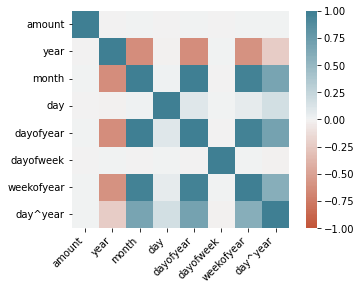

In [55]:
import seaborn as sns
corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [56]:
print(train)
print(test)
train = pd.get_dummies(train, columns=['product_id'])
test = pd.get_dummies(test, columns=['product_id'])

       product_id  amount  year  month  day  dayofyear  dayofweek  weekofyear  \
0            1002       1  2019      8    1        213          3          31   
1            1003       0  2019      8    1        213          3          31   
2            1004       0  2019      8    1        213          3          31   
3            1005       0  2019      8    1        213          3          31   
4            1006       1  2019      8    1        213          3          31   
...           ...     ...   ...    ...  ...        ...        ...         ...   
137580       1081       1  2021      6   29        180          1          26   
137581       1082       0  2021      6   29        180          1          26   
137582       1083       0  2021      6   29        180          1          26   
137583       1084       0  2021      6   29        180          1          26   
137584       1085       0  2021      6   29        180          1          26   

         day^year  
0      

In [57]:
X_train = train.drop('amount', axis=1)
y_train = train['amount']
X_test=test.drop('amount',axis=1)
y_test=test['amount']
df_train = train.copy()

# # Train Test Split
X_train , X_test ,y_train, y_test = train_test_split(df_train.drop('amount',axis=1),df_train.pop('amount'),
                                                     random_state=42, test_size=0.2)

xgbr = xgb.XGBRegressor(verbosity=0) 
print(xgbr)
xgbr.fit(X_train, y_train)

score = xgbr.score(X_train, y_train)   
print("Training score: ", score) 

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=0)
Training score:  0.555756770744645


In [58]:
ypred = xgbr.predict(X_test)

In [60]:
test.plot(y='amount',x='date')

KeyError: 'date'